# 자녀 성장수준 도식화

Process engineer라는 업의 특성 때문인지 어떤 특성에 대한 숫자화와 이력 관리에 대한 강박이 있는 편이다. 

두 아이와 조카의 신체 성장 기록을 엑셀 시트로 수 년간 관리했었는데 Pandas skill practice 일환으로 Notebook version으로 migration 해보았다.

In [1]:
# Improt libraries
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')  # 시각화를 위해 'seaborn-whithgrid' 스타일 적용
# plt.rcParams.update({'font.size': 16})

import seaborn as sns
import scipy.stats as ss

In [2]:
# Children birth infomation for data index, month from birth
birth = {'Ariel': pd.Timestamp('2012-01-28'), \
         'Ted': pd.Timestamp('2013-09-28'), \
         'Jua': pd.Timestamp('2014-11-10')}

# MONTHS_FROM_BIRTH 열 생성을 위한 apply 적용 시 사용
def month_diff(row):   
    return (row.DATE - birth[row.PERSON]).days // 30

# 소아청소년 성장도표 읽어오기
def read_table_from_excel(sheet):
    col = ['GENDER', 'AGE_YEAR', 'AGE_MONTH', 'L', 'M', 'S', \
       'PER_1', 'PER_3', 'PER_5', 'PER_10', 'PER_15', 'PER_25', 'PER_50', \
       'PER_75', 'PER_85', 'PER_90', 'PER_95','PER_97', 'PER_99', \
       '-3SD', '-2SD', '-1SD', '0SD', '+1SD', '+2SD', '+3SD']
    
    table = pd.read_excel('growth-table.xls', sheet_name= sheet, skiprows= 2, header= None)
    table.columns = col

    table.drop('AGE_YEAR', axis= 1, inplace= True)
    table.set_index('AGE_MONTH', inplace= True)
    
    return table

# 성장도표와 개별 성장 데이터 그래프 생성
def growth_comparison_plot(gender, people, table, col_name):
    # 백분위표에서 필요한 열만 선택
    comparison_col = ['PER_10', 'PER_25', 'PER_50', 'PER_75', 'PER_90']
    
    table.loc[table.GENDER == gender, comparison_col].plot(linestyle= ':')
    for person in people:
        df.loc[df.PERSON == person, col_name].dropna(axis=0).plot(marker='.', figsize= (8, 6))
    
    ylabeldict = {'HEIGHT': 'Height (cm)', 'WEIGHT': 'Weight (kg)', 'BMI': 'Body Mass Index', 'HEAD': 'Head-around (cm)'}
    
    plt.title(col_name)
    plt.legend(comparison_col + people)
    plt.xlabel('Months from birth')
    plt.ylabel(ylabeldict[col_name])
    plt.show()

# 개별 성장 데이터 내 백분위값 변환
def percentile(row, item):
    table_dict = {'HEIGHT': height, 'WEIGHT': weight, 'BMI': bmi}
    
    mfb = row.MONTHS_FROM_BIRTH
    
    x= row.loc[item]
    l = table_dict[item].loc[(table_dict[item].index == mfb) & (table_dict[item].GENDER == row.GENDER), :].L
    m = table_dict[item].loc[(table_dict[item].index == mfb) & (table_dict[item].GENDER == row.GENDER), :].M
    s = table_dict[item].loc[(table_dict[item].index == mfb) & (table_dict[item].GENDER == row.GENDER), :].S

    Z = ((x / m) ** l - 1) / (l * s)
    perc = ss.norm.cdf(Z) * 100
    
    try:
        return perc[0]
    except:
        return np.nan

In [3]:
df = pd.read_csv('children-growth.csv')

df.DATE = pd.to_datetime(df.DATE)  # Change dtype from string to pandas datetime
df['MONTHS_FROM_BIRTH'] = df.apply(month_diff, axis=1)  # Create new column, months from birth
df['BMI'] = df.WEIGHT / df.HEIGHT / df.HEIGHT * 10000  # Create new column, BMI - Body Mass Index
df['GENDER'] = df.PERSON.map({'Ariel': 2, 'Ted': 1, 'Jua': 2})  # Create new column, Male = 1, Female = 2

df.set_index('MONTHS_FROM_BIRTH', inplace=True)
df.sort_index(inplace= True)

df.head()

,PERSON,DATE,WEIGHT,HEIGHT,HEAD,BMI,GENDER
MONTHS_FROM_BIRTH,,,,,,,
12,Ted,2014-09-23,11.3,77.3,NaN,18.911216,1
17,Ted,2015-03-19,12.8,80.8,49.5,19.605921,1
18,Ted,2015-04-19,12.0,82.0,49.0,17.846520,1
18,Ted,2015-04-10,13.0,83.0,NaN,18.870663,1
20,Ted,2015-06-03,13.2,82.0,NaN,19.631172,1


정리된 측정 결과이다. 각 열의 정보는 아래와 같다.

* MONTHS_FROM_BIRTH : 생후개월 (측정일 - 출생일의 월 변환)
* PERSON : 측정 대상 - 본 데이터에는 3명 존재 (Ariel, Ted, Jua)
* DATE : 측정 일자
* WEIGHT : 몸무게 (kg)
* HEIGHT : 키 (cm)
* HEAD : 머리둘레 (cm)
* BMI : Body Mass Index (몸무게 / 키^2)
* GENDER : 성별 (남자1, 여자2)

In [4]:
df.shape

(77, 7)

In [5]:
df.dtypes

PERSON            object
DATE      datetime64[ns]
WEIGHT           float64
HEIGHT           float64
HEAD             float64
BMI              float64
GENDER             int64
dtype: object

In [6]:
df.describe(include= 'all')

,PERSON,DATE,WEIGHT,HEIGHT,HEAD,BMI,GENDER
count,77,77,77.000000,77.000000,43.000000,77.000000,77.000000
unique,3,46,NaN,NaN,NaN,NaN,NaN
top,Ariel,2019-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,37,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2014-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,20.315584,106.763636,50.253488,17.444360,1.597403
std,NaN,NaN,6.372785,14.687570,1.717466,1.321455,0.493637
min,NaN,NaN,11.300000,77.300000,46.000000,15.304496,1.000000
25%,NaN,NaN,16.000000,96.200000,49.250000,16.261027,1.000000


세 아이들의 생후개월 대비 키 성장을 비교한 값이다. Ariel의 경우, 가장 나이가 많다보니 나머지 두 아이들에 비해 키가 굉장히 크다는 평가를 집안 어른들로부터 많이 받는 편이다. 하지만 데이터 를 비교할 경우, 실제 세 아이들의 키 성장은 생후 70개월까지는 큰 차이가 없이 거의 비슷함을 확인할 수 있다. 오히려 70개월 차부터는 Ted의 키가 갑자기 컸음을 알 수 있다.

또한 아이들의 키 성장이 생후 100개월 내외까지는 선형 모델과 유사한 것을 추정된다. 예를 들어 아래 Ariel 키 값을 가지고 regression plot을 그려보았을 때 1차 선형모델과 꽤 근사하게 확인된다 (물론 100개월 전후로 1차 선형에서 벗어나려는 모양이 일부 확인되는 듯 하다). 이에 대한 자세한 내용은 대한민국 소아 및 청소년 성장도표와 함께 추가적으로 살펴보도록 하자.

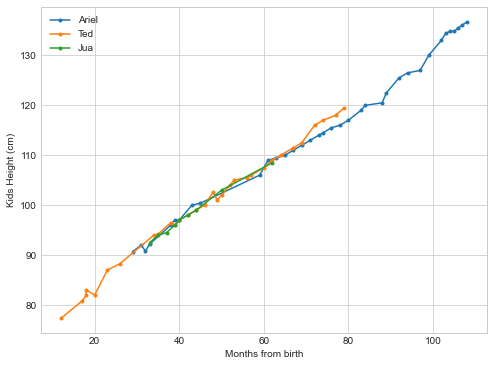

In [7]:
for person in birth:
    df.loc[df.PERSON == person, 'HEIGHT'].plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Kids Height (cm)')
plt.show()

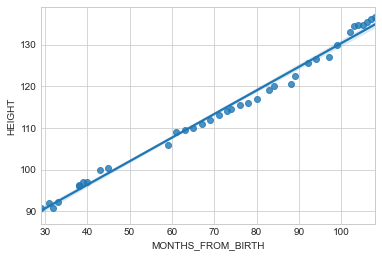

In [8]:
sns.regplot(data= df.loc[df.PERSON == 'Ariel', :].reset_index(), x= 'MONTHS_FROM_BIRTH', y='HEIGHT')

키와 달리 몸무게는 세 아이가 차이를 보인다. Ted의 경우, 남자 아이라서 다른 두 여자 아이에 비해 몸무게가 높은 편이다. 다른 특이점으로는 Ariel의 몸무게가 90개월을 지나는 시점에서 갑자기 크게 증가하였다.

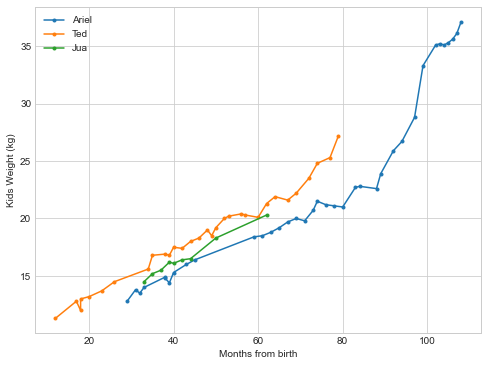

In [9]:
for person in birth:
    df.loc[df.PERSON == person, 'WEIGHT'].plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Kids Weight (kg)')
plt.show()

키와 몸무게의 성장은 당연하게 같이 수반되는 것이지만 때로는 키에 비해 몸무게가 과다하거나 부족하여 비만이나 체중미달의 위험에 도달하기도 한다. 이를 확인하는 간단한 지표로 BMI를 사용할 수 있다. Body Mass Index는 몸무게를 키의 제곱값으로 나눈 결과이다.

Ted의 몸무게가 다른 두 여자아이 대비하여 높았지만 BMI는 18~19 내외에서 유지되고 있음을 확인할 수 있다. 오히려, Ariel의 BMI가 최근 16에서 19.5까지 크게 증가하였다. 성장기에 키와 몸무게의 증가는 당연하나 비만의 우려가 있으므로 관리가 필요한 시점임을 알 수 있다.

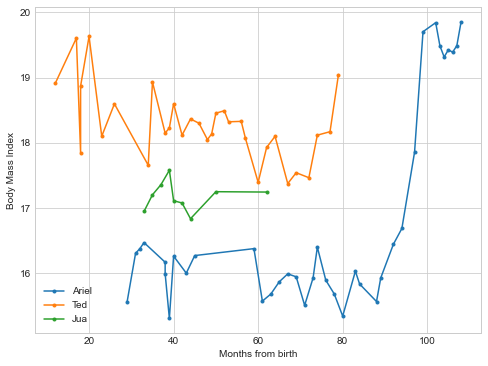

In [10]:
for person in birth:
    df.loc[df.PERSON == person, 'BMI'].plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Body Mass Index')
plt.show()

머리둘레의 경우, 키나 몸무게에 비해 누락데이터가 많은 편이다. 실제 측정해 보니 측정위치가 동일하지 않거나 아이들의 머리 상태(머리숱 및 핀 등을 통한 꾸밈 상태)에 따라 으면 오차가 제법 발생하는 편이었다. 

머리 둘레의 경우, 아래의 결과를 확인했다.
1. 키나 몸무게에 비해 머리둘레의 성장은 빠르지 않다. 즉, 초기값이 유지되며 서서히 증가한다.
2. 따라서 초기값이 중요하다 (아직 결론 내리기에 데이터가 부족하나 소두와 대두는 어릴 때부터 타고나는 것 같다.)

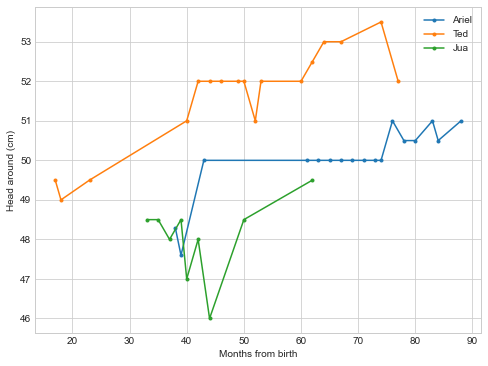

In [11]:
for person in birth:
    df.loc[df.PERSON == person, 'HEAD'].dropna(axis= 0).plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Head around (cm)')
plt.show()

지금까지 세 아이들의 측정결과를 생후개월 대비하여 확인해보았다. 이제 내가 가지고 있는 dataset을 넘어 다른 아이들과의 비교를 통해 우리 아이들의 성장 수준을 확인해 보도록 하자.

질병관리청에서 소아청소년 성장 수준 통계를 도표로 제공하고 있다 (http://www.cdc.go.kr/contents.es?mid=a20303030400). 이를 지금까지의 데이터와 병기하여 확인해보자.

In [12]:
height = read_table_from_excel('연령별 신장')
weight = read_table_from_excel('연령별 체중')
bmi = read_table_from_excel('연령별 체질량지수')
head = read_table_from_excel('연령별 머리둘레')

In [13]:
height.head()

,GENDER,L,M,S,PER_1,PER_3,PER_5,PER_10,PER_15,PER_25,...,PER_95,PER_97,PER_99,-3SD,-2SD,-1SD,0SD,+1SD,+2SD,+3SD
AGE_MONTH,,,,,,,,,,,,,,,,,,,,,
0,1,1.0,49.8842,0.0380,45.5,46.3,46.8,47.5,47.9,48.6,...,53.0,53.4,54.3,44.2,46.1,48.0,49.9,51.8,53.7,55.6
1,1,1.0,54.7244,0.0356,50.2,51.1,51.5,52.2,52.7,53.4,...,57.9,58.4,59.3,48.9,50.8,52.8,54.7,56.7,58.6,60.6
2,1,1.0,58.4249,0.0342,53.8,54.7,55.1,55.9,56.4,57.1,...,61.7,62.2,63.1,52.4,54.4,56.4,58.4,60.4,62.4,64.4
3,1,1.0,61.4292,0.0333,56.7,57.6,58.1,58.8,59.3,60.1,...,64.8,65.3,66.2,55.3,57.3,59.4,61.4,63.5,65.5,67.6
4,1,1.0,63.8860,0.0326,59.0,60.0,60.5,61.2,61.7,62.5,...,67.3,67.8,68.7,57.6,59.7,61.8,63.9,66.0,68.0,70.1


성장도표는 남아와 여아의 발달 수준이 서로 다르기 때문에 성별로 다른 값을 제공하고 있다. 우선 여자 아이들의 성장 수준을 확인해보자.

키 성장의 경우, Ariel과 Jua 모두 70개월 내외까지 약 50% 수준에서 성장함을 알 수 있다. Ariel의 경우, 100개월(만 8세) 전후하여 키 성장이 급격하게 발생하여 백분위 기준 75% 수준까지 도달하였다 (상위 25% 의미).

성장 도표를 확인할 때, 약 40개월에서 130개월 내외까지 키 성장이 모든 백분위값에 대해 1차 선형식과 근사하게 증가하고 있음을 알 수 있다. 이 시기가 통계적으로 볼 때 대부분의 성장이 이루어 지는 구간이며, 150개월을 넘어가면 대부분의 성장이 멈추게 된다 (남녀 차이는 존재).

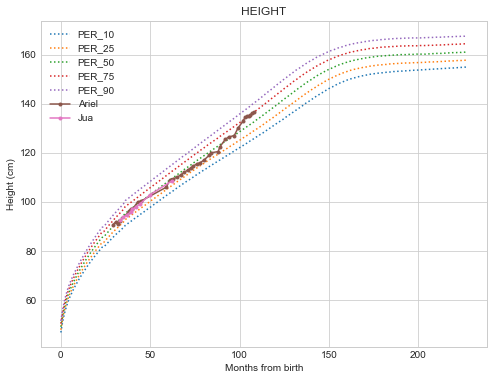

In [14]:
growth_comparison_plot(2, ['Ariel', 'Jua'], height, 'HEIGHT')

몸무게의 경우, Jua는 75% 수준에서 유지 중이다 (상위 25%). Ariel의 경우 50% 내외에서 유지되던 몸무게가 100개월 전후하여 약 80% 수준까지 크게 증가하였다. 이로 인해 BMI 수치도 같이 크게 증가되었음을 알 수 있다.

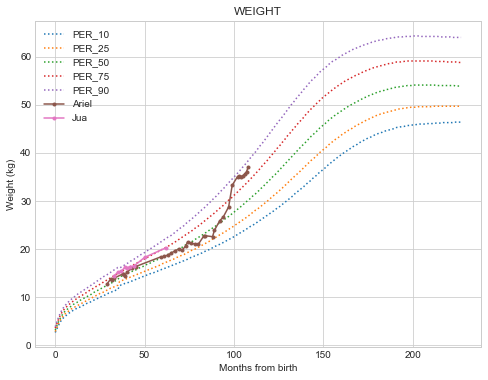

In [15]:
growth_comparison_plot(2, ['Ariel', 'Jua'], weight, 'WEIGHT')

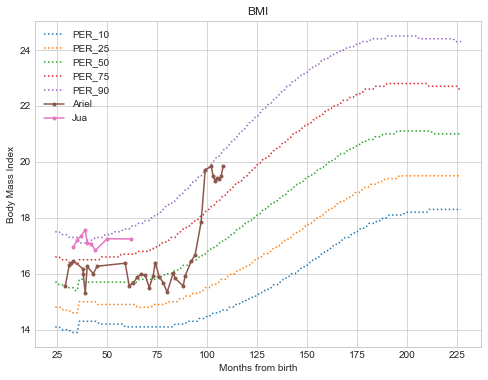

In [16]:
growth_comparison_plot(2, ['Ariel', 'Jua'], bmi, 'BMI')

머리 둘레의 경우, 생후 70개월차까지만 성장도표를 제공하고 있다. 아이들의 개별 데이터도 측정오차가 분명하여 비교 결과를 분석하기 어렵다.

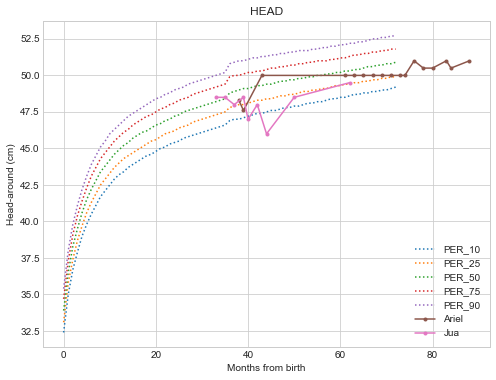

In [17]:
growth_comparison_plot(2, ['Ariel', 'Jua'], head, 'HEAD')

이제 Ted의 성장 수준을 대한민국 남아 평균과 비교하여 확인해보자.

키의 경우, 50% 내외에서 잘 성장하고 있음을 알 수 있다.

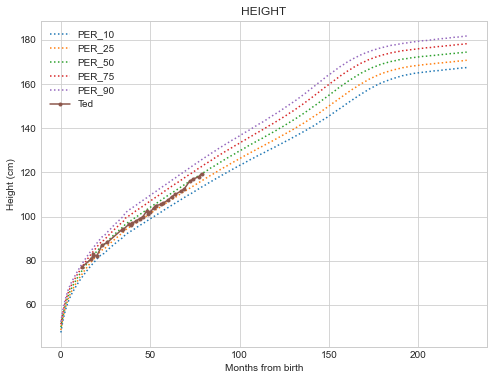

In [18]:
growth_comparison_plot(1, ['Ted'], height, 'HEIGHT')

몸무게는 다소 높은 편이다. 약 75% 내외에서 거동하고 있다.

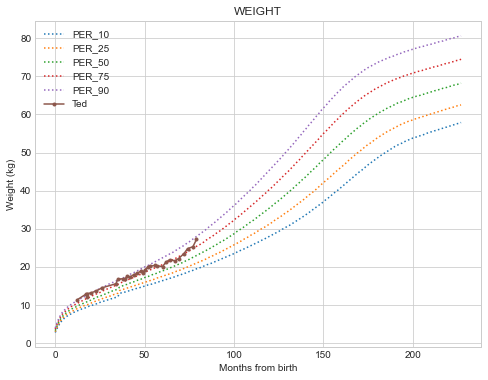

In [19]:
growth_comparison_plot(1, ['Ted'], weight, 'WEIGHT')

키에 비해 높은 몸무게로 인해 BMI의 백분위 값은 높은 편이다. 다행스러운 점은 다른 아이들에 비해 BMI 값이 일정하게 유지되면서 백분위 기준으로는 정상 수준을 돌아오는 것을 보인다 (혹은 기대한다...)

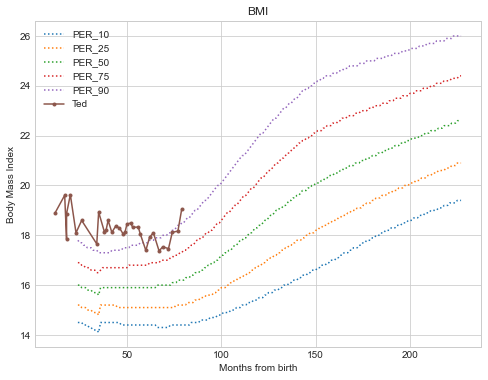

In [20]:
growth_comparison_plot(1, ['Ted'], bmi, 'BMI')

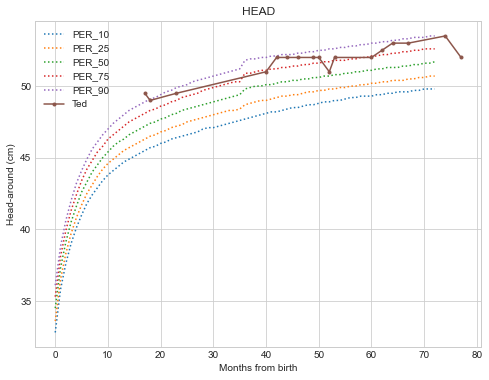

In [21]:
growth_comparison_plot(1, ['Ted'], head, 'HEAD')

추가적으로 다른 아이들 대비하여 우리 아이들의 백분위 기준 성장은 어떻게 변화하는 지 살펴볼 수 있을 듯 하다. 성장도표에는 생후개월과 측정결과를 백분위 값으로 변환할 수 있도록 관련 상수인 L, M, S 값을 제공하고 있다.

측정 결과인 x에 대해 Z-score는 아래의 공식으로 계산 가능하다.
```
Z = (((x / M) ** L) - 1) / (L * S)
```

계산된 Z-score는 scipy.stats 라이브러리의 norm.cdf를 활용하여 누적 백분위 값으로 변환하도록 한다.

In [22]:
df.reset_index(inplace=True)

df['HEIGHT_PER'] = df.apply(percentile, item= 'HEIGHT', axis='columns')
df['WEIGHT_PER'] = df.apply(percentile, item= 'WEIGHT', axis='columns')
df['BMI_PER'] = df.apply(percentile, item= 'BMI', axis='columns')

In [23]:
df.head()

,MONTHS_FROM_BIRTH,PERSON,DATE,WEIGHT,HEIGHT,HEAD,BMI,GENDER,HEIGHT_PER,WEIGHT_PER,BMI_PER
0,12,Ted,2014-09-23,11.3,77.3,NaN,18.911216,1,74.285501,92.696019,NaN
1,17,Ted,2015-03-19,12.8,80.8,49.5,19.605921,1,43.253471,94.456942,NaN
2,18,Ted,2015-04-19,12.0,82.0,49.0,17.846520,1,46.180682,79.777774,NaN
3,18,Ted,2015-04-10,13.0,83.0,NaN,18.870663,1,60.824599,94.009074,NaN
4,20,Ted,2015-06-03,13.2,82.0,NaN,19.631172,1,21.706471,91.163301,NaN


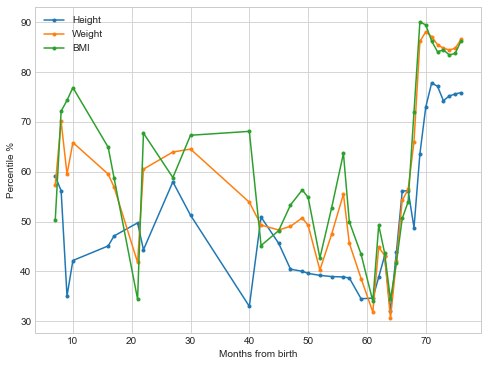

In [24]:
df.loc[df.PERSON == 'Ariel', ['HEIGHT_PER', 'WEIGHT_PER', 'BMI_PER']].plot(marker= '.', figsize= (8, 6))

plt.legend(['Height', 'Weight', 'BMI'])
plt.xlabel('Months from birth')
plt.ylabel('Percentile %')
plt.show()

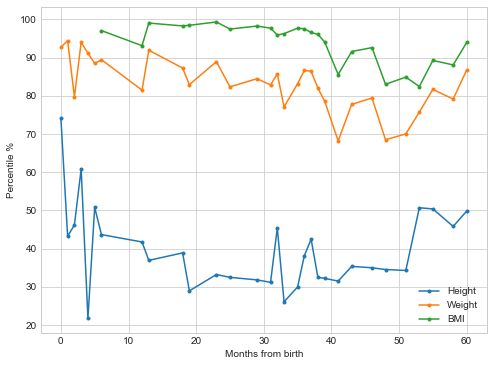

In [25]:
df.loc[df.PERSON == 'Ted', ['HEIGHT_PER', 'WEIGHT_PER', 'BMI_PER']].plot(marker= '.', figsize= (8, 6))

plt.legend(['Height', 'Weight', 'BMI'])
plt.xlabel('Months from birth')
plt.ylabel('Percentile %')
plt.show()

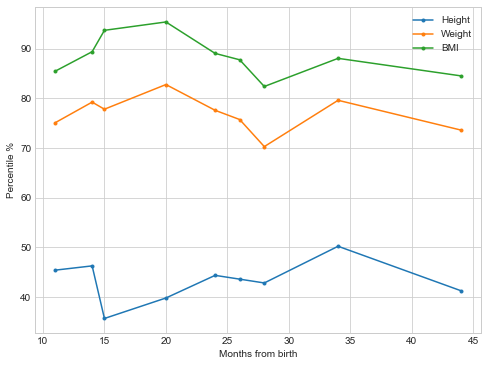

In [26]:
df.loc[df.PERSON == 'Jua', ['HEIGHT_PER', 'WEIGHT_PER', 'BMI_PER']].plot(marker= '.', figsize= (8, 6))

plt.legend(['Height', 'Weight', 'BMI'])
plt.xlabel('Months from birth')
plt.ylabel('Percentile %')
plt.show()